# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Rubric Points
##### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.
------



## Writeup / README
##### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. Here is a template writeup for this project you can use as a guide and a starting point.

You're reading it!
### All of my codes are in the Jupyter notebook named `t-yamada.ipynb`.

----

## Import Libraries

In [1]:
#1. 
#Import Libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline

## Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.



The code for this step is contained in the #2 code cells of the Jupyter notebook `t-yamada.ipynb`.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in real world.
Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.
Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image by using `cv2.findChessboardCorners()`.
`imgpoints`,which are chessboard corners in 2d image, will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

To show the result of finding chessboard corners clearly, I used `plt.subplots` to show all the corners' captured chessboard images.
Note: Some of the chessboard images don't appear because in some cases, `cv2.findChessboardCorners` was not able to detect the requested number of internal corners.

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the result attached below.

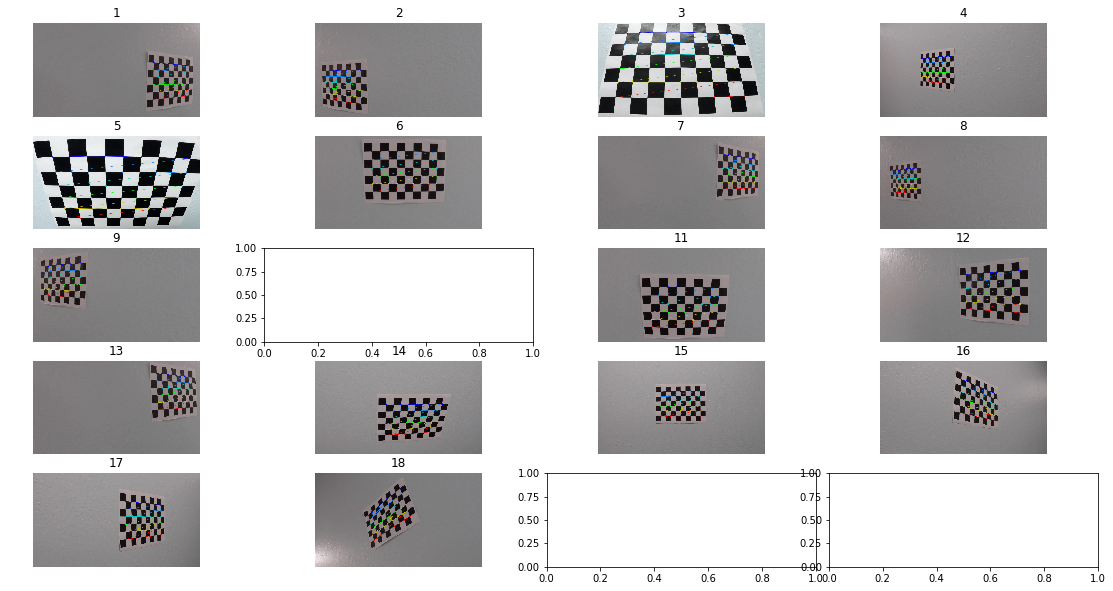

In [2]:
#2 
#prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# prep for 5x4 multi-plot
fig, axs = plt.subplots(5, 4 , figsize=(20, 10))
fig.subplots_adjust(hspace = 0.2, wspace=0.05)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i,fname in enumerate(images):   #for-loop with indexing
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        axs[i].set_title(i+1)
        

### Undistortion

Text(0.5,1,'Undistorted Image')

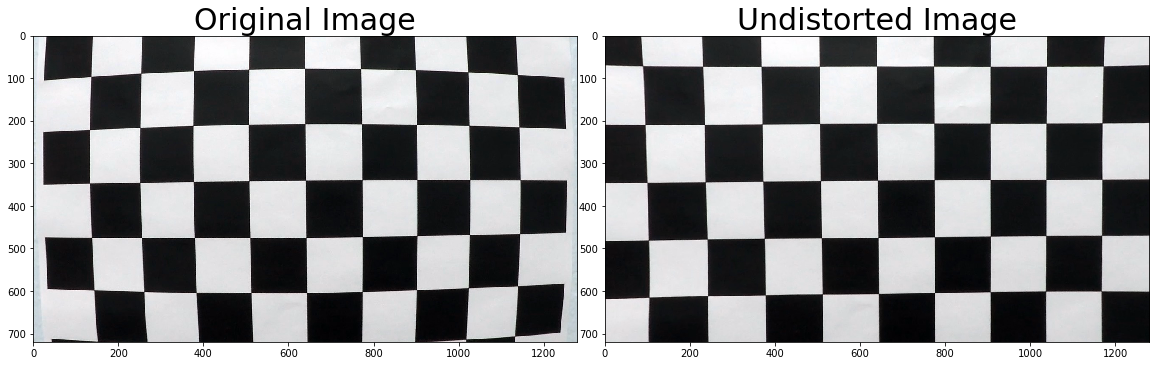

In [3]:
#3 
#Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

The images below are before and after applying `cv2.undistort` function to one of images in test_images folder.

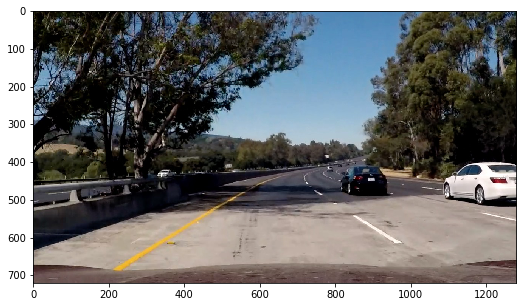

In [4]:
#4 
#Choose an image from which to build and demonstrate each step of the pipeline
exampleImg = cv2.imread('./test_images/test5.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,5))
plt.imshow(exampleImg)

Text(0.5,1,'Undistorted Image')

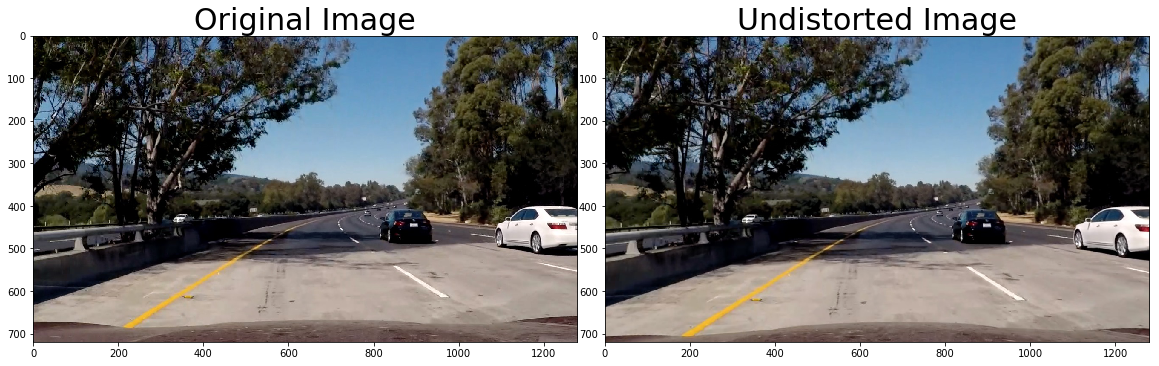

In [5]:
#5 
#undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

exampleImg_undistort = undistort(exampleImg)

#visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I tried sobel gradients and HSL,Luv,Lab color channel by tweaking lower and higher thresholds. 

Especially, L-channel from Luv is aiming for white lane line, b-channel from Lab is aiming for yellow lane line. 

The codes and result images are in the Jupyter notebook. 

Below is an example of HLS S-channel.

Text(0.5,1,'Sobel Absolute X')

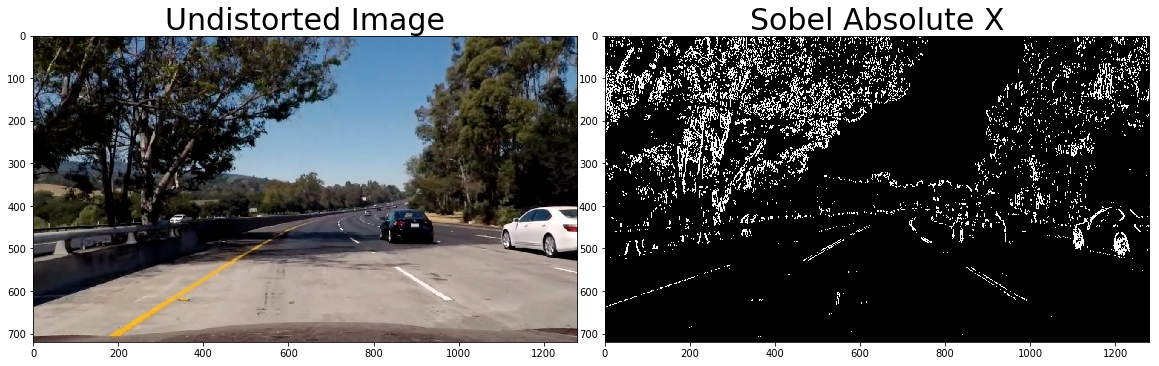

In [6]:
#6 
#Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as binary_output image
    return sxbinary


min_thresh = 25
max_thresh = 255

exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_undistort, 'x', min_thresh, max_thresh)
# Visualize sobel absolute threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_sobelAbs, cmap='gray')
ax2.set_title('Sobel Absolute X', fontsize=30)

In [7]:
#7 
#Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as binary_output image
    return sxbinary


kernel_size = 9
min_thresh = 30
max_thresh = 150

exampleImg_sobelMag = mag_thresh(exampleImg_undistort, kernel_size, (min_thresh, max_thresh))
# Visualize sobel magnitude threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_sobelMag, cmap='gray')
ax2.set_title('Sobel Magnitude', fontsize=30)


Text(0.5,1,'Sobel Magnitude')

Text(0.5,1,'Sobel Direction')

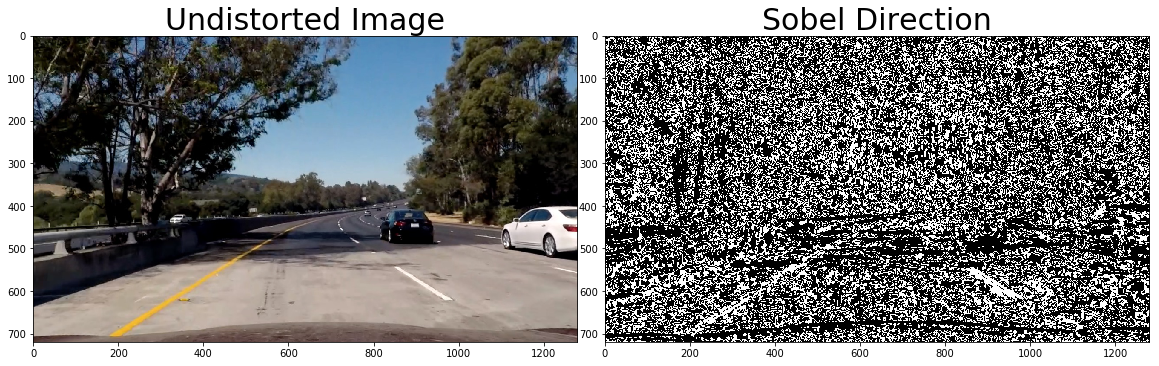

In [8]:
#8 
#Define a function that applies Sobel x and y, 
# then computes the direction of the gradient and applies a threshold.
def dir_thresh(img, sobel_kernel=15, thresh=(0.7, 1.3)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as binary_output image
    return binary_output


kernel_size = 15
min_thresh = 0.7
max_thresh = 1.3

exampleImg_sobelDir = dir_thresh(exampleImg_undistort, kernel_size, (min_thresh, max_thresh))
# Visualize sobel direction threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_sobelDir, cmap='gray')
ax2.set_title('Sobel Direction', fontsize=30)


Text(0.5,1,'Sobel Magnitude + Direction')

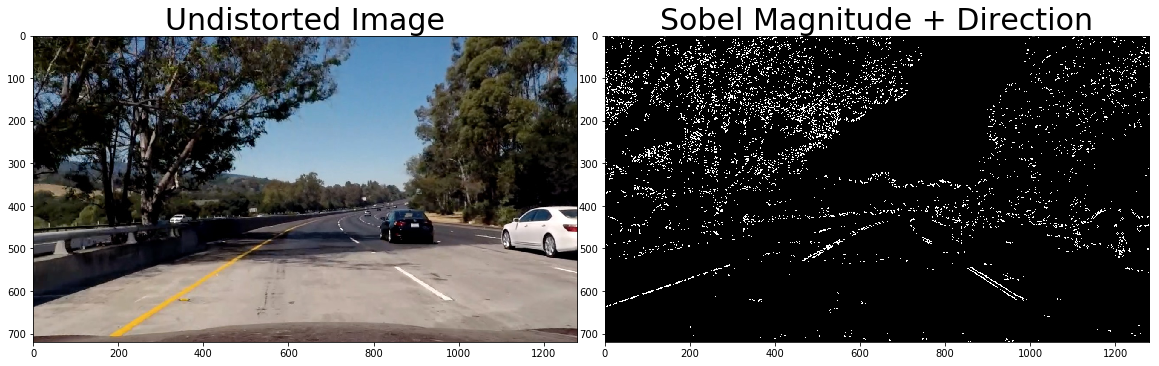

In [9]:
#9 
#combination of sobel magnitude & sobel direction

mag_kernel_size = 9
mag_min_thresh = 30
mag_max_thresh = 150

dir_kernel_size = 15
dir_min_thresh = 0.7
dir_max_thresh = 1.3

exampleImg_sobelMag2 = mag_thresh(exampleImg_undistort, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
exampleImg_sobelDir2 = dir_thresh(exampleImg_undistort, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
Mag2Dir2combined = np.zeros_like(exampleImg_sobelMag2)
Mag2Dir2combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
# Visualize sobel magnitude + direction threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(Mag2Dir2combined, cmap='gray')
ax2.set_title('Sobel Magnitude + Direction', fontsize=30)

Text(0.5,1,'HLS S-Channel')

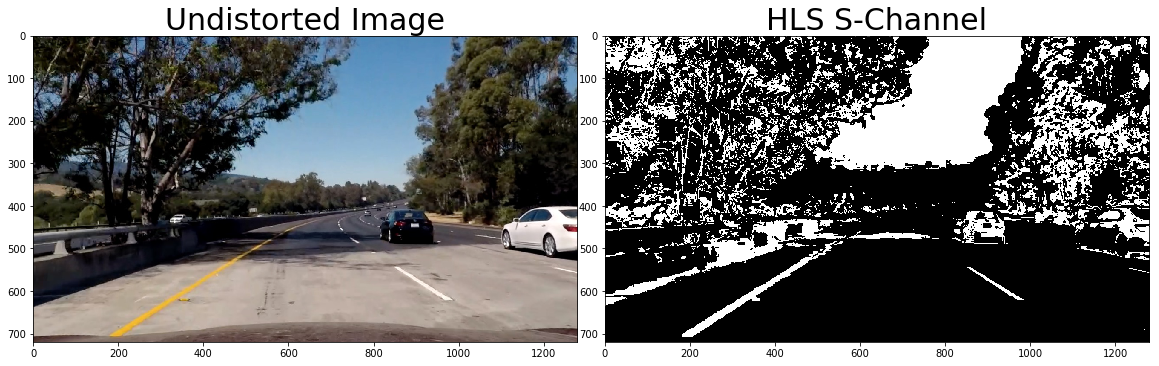

In [10]:
#10 
#Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


min_thresh = 90
max_thresh = 255


exampleImg_SThresh = hls_sthresh(exampleImg_undistort, (min_thresh, max_thresh))
# Visualize hls s-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_SThresh, cmap='gray')
ax2.set_title('HLS S-Channel', fontsize=30)


Text(0.5,1,'HLS L-Channel')

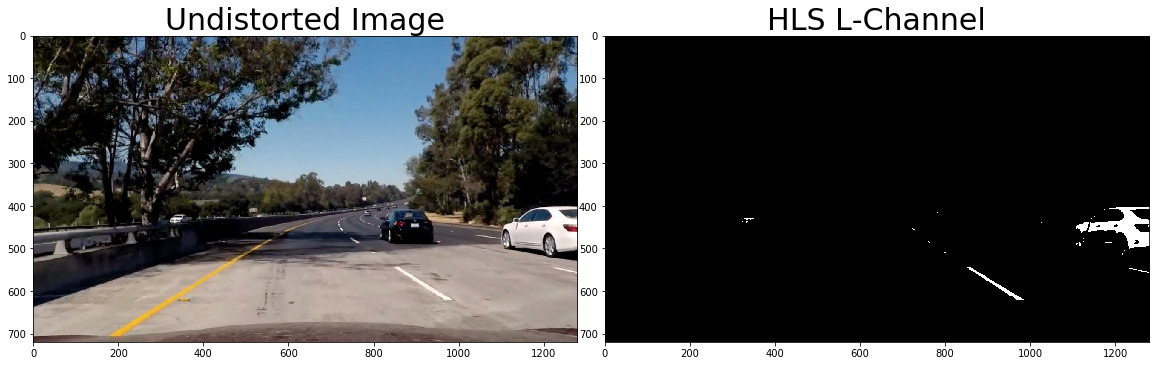

In [11]:
#11-0 
#Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

min_thresh = 220
max_thresh = 255

exampleImg_LThresh = hls_lthresh(exampleImg_undistort, (min_thresh, max_thresh))
# Visualize hls l-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_LThresh, cmap='gray')
ax2.set_title('HLS L-Channel', fontsize=30)


Text(0.5,1,'Luv L-Channel')

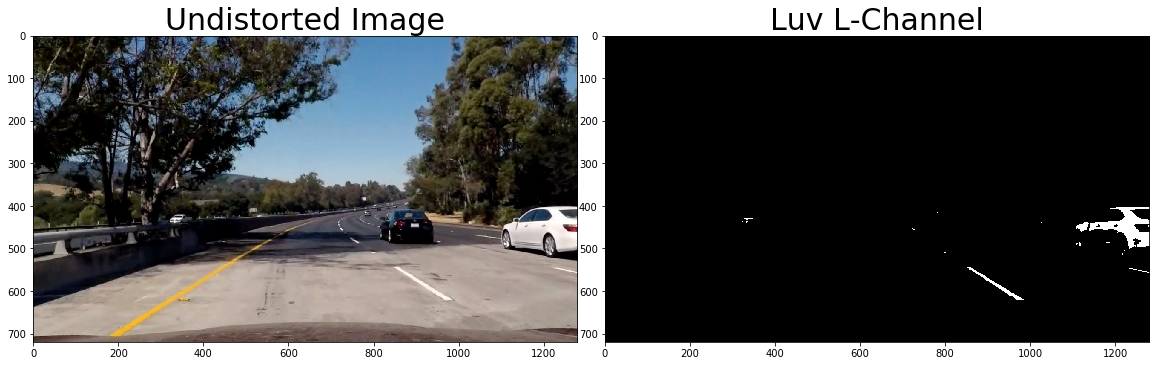

In [12]:
#11-1 
#Define a function that thresholds the L channel from Luv
# Use exclusive lower bound (>) and inclusive upper (<=)
def luv_lthresh(img, thresh=(225, 255)):
    # 1) Convert to Luv color space
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    luv_l = luv[:,:,0]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(luv_l)
    binary_output[(luv_l > thresh[0]) & (luv_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

min_thresh = 225
max_thresh = 255

exampleImg_LThresh = luv_lthresh(exampleImg_undistort, (min_thresh, max_thresh))
# Visualize Luv L-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_LThresh, cmap='gray')
ax2.set_title('Luv L-Channel', fontsize=30)


In [13]:
#11-12
#Define a function that thresholds the b channel from Lab
# Use exclusive lower bound (>) and inclusive upper (<=)
def lab_bthresh(img, thresh=(155, 200)):
    # 1) Convert to Lab color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[(lab_b > thresh[0]) & (lab_b <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

min_thresh = 155
max_thresh = 200

exampleImg_LThresh = lab_bthresh(exampleImg_undistort, (min_thresh, max_thresh))
# Visualize Lab b-channel threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_LThresh, cmap='gray')
ax2.set_title('Lab b-Channel', fontsize=30)


Text(0.5,1,'Lab b-Channel')

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for perspective transform is in the code cell #12 in the Jupyter notebook. 
The unwarp() function takes as inputs an gray image (`gray`), source (`src`) and destination (`dst`) points.

I assumed that the camera position remain constant and that the road in the videos will remain relatively flat.
So I selected source and destination points considering straight_lines image in `test_images` folder for reference.

The images below are results of the perspective transform.

(720, 1280)


Text(0.5,1,'Unwarped Image')

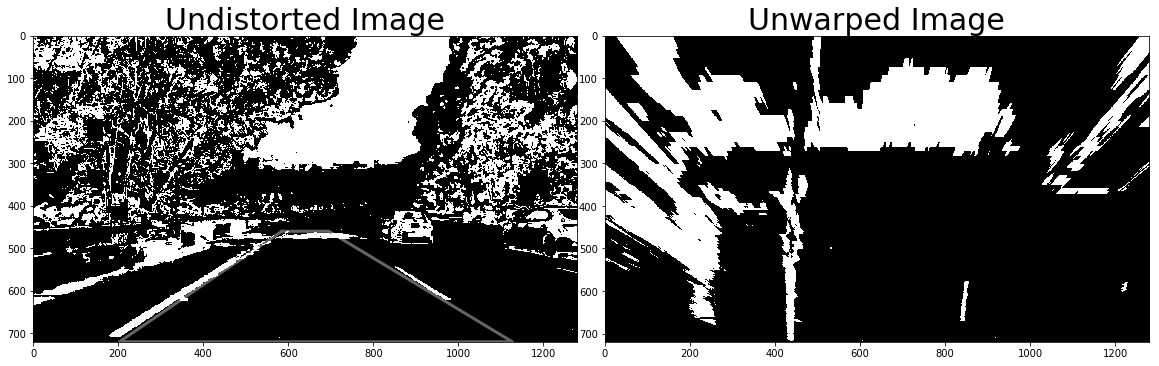

In [14]:
#12
# unwarp the gray image

def unwarp(gray, src, dst):
    img_size = (gray.shape[1], gray.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M =    cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(gray, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

 
InputGrayImg = np.copy(exampleImg_SThresh)
h,w = InputGrayImg.shape
print((h,w))

# define source and destination points for transform
#src = np.float32([(575,464),
#                  (707,464), 
#                  (258,682), 
#                  (1049,682)])

src = np.float32([(585,460),
                  (695,460), 
                  (203,720), 
                  (1127,720)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])




exampleImg_unwarp, M, Minv = unwarp(InputGrayImg, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(InputGrayImg,cmap='gray')
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#ffffff', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp,cmap='gray')
ax2.set_title('Unwarped Image', fontsize=30)


### Image Processing Pipeline
After examining, I chose to use the condition as below.

(HLS S-channel) OR (HLS L-channel) OR (Luv L channel) OR (Lab b channel)

The below images are the transition from original image.

The left is original image, the middle is undistorted and thresholded through above conditions, the right is perspective transformed one.


In [15]:
#13 
#Define the complete image processing pipeline, reads raw image and returns binary image of bird-view
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Sobel Absolute
    img_sobelAbs = abs_sobel_thresh(img_undistort,'x',25,255)
    
    # Sobel Magnitude
    img_sobelMag = mag_thresh(img_undistort,15,(30,255))
    
    # Sobel Direction
    img_sobelDir = dir_thresh(img_undistort,15,(0.7,1.3))
    
    # HLS S-channel Threshold
    img_SHLSThresh = hls_sthresh(img_undistort,(90,255))
    
    # HLS L-channel Threshold
    img_LHLSThresh = hls_lthresh(img_undistort,(220,255))
    
    # Luv L channel Threshold
    img_LLuvThresh = luv_lthresh(img_undistort,(225,255))
    
    # Lab b channel Threshold
    img_bLabThresh = lab_bthresh(img_undistort,(155, 200))
    
    
    # Combine thresholds
    combined = np.zeros_like(img_SHLSThresh)
#    combined[((img_sobelMag == 1)&(img_sobelDir == 1)) | (img_SThresh == 1)| (img_LThresh == 1)] = 1
#    combined[((img_sobelMag == 1)&(img_sobelDir == 1)) | (img_SHLSThresh == 1)| (img_LHLSThresh == 1)| (img_LLuvThresh == 1)| (img_bLabThresh == 1)] = 1
#    combined[((img_sobelMag == 1)&(img_sobelDir == 1)) |  (img_LHLSThresh == 1)| (img_LLuvThresh == 1)| (img_bLabThresh == 1)] = 1
    combined[ (img_LHLSThresh == 1)| (img_LLuvThresh == 1)| (img_bLabThresh == 1)] = 1
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(combined, src, dst)
    return img_undistort,combined,img_unwarp, Minv

    
    
# Make a list of example images
images = glob.glob('./test_images/*.jpg')

# Set up plot
fig, axs = plt.subplots(len(images),3, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_undistort,img_bin_threshed,img_bin, Minv = pipeline(img)
    axs[i].imshow(img_undistort)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin_threshed, cmap='gray')
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The functions `sliding_window_polyfit` and `polyfit_using_prev_fit`, which identify lane lines and fit a second order polynomial to both right and left lane lines, are codel cell #14 & #17 in the Jupyter notebook.

`sliding_window_polyfit` uses a histogram of lower half of the image, and find the bottom-most x position of the left and right lane. 
In the original function in the lesson, these locations were identified from the local maximum of the left and right half of the histogram, but in below implementation I changed "half" to "quarter" of the histogram just left and right of the midpoint,which resulted in better detection after several trials.

Pixels in each lane line are identified in the sliding windows and the `np.polyfit()` function finds a second order polynomial to each set of pixels. The image below demonstrates how this process works:


In [16]:
#14 
#Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization (4 ocrners' coordinates of two windows)
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

(720, 0)

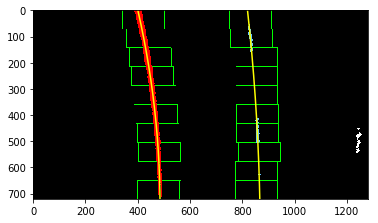

In [17]:
#15
#visualize the result on example image
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_undistorted,exampleImg_combined,exampleImg_bin, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

rectangles = visualization_data[0]
histogram = visualization_data[1]


# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(0, 1280)

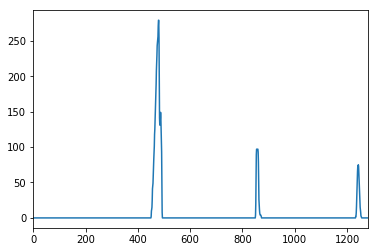

In [18]:
#16 
#Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)

The `polyfit_using_prev_fit` function performs basically the same task, 
but it is a bit easier search process by comparing a previous fit and only searching for lane pixels within a certain range of that fit.
The image below demonstrates this - the green area is the range from the previous fit, and the yellow lines and red and blue pixels are from the current image:

(720, 0)

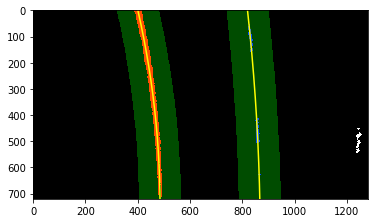

In [19]:
#17 
#Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test2.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_undistorted,exampleImg2_combined, exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]


# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The codes of calculation is in the code cell #18.

`y_meters_per_pixel` and `x_meters_per_pixel` are the factors used for converting from pixels to meters. 

The radius of curvature is based upon the website(https://www.intmath.com/applications-differentiation/8-radius-curvature.php).

Position of the vehicle is considered as the center of the image, so distance from the mid-point of detected left and right lane line is "the position of the vehicle with respect to center".

In [20]:
#18
#Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        
            
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')


Radius of curvature for example: 312.492867598 m, 768.685896118 m
Distance from lane center for example: -0.351796051199 m


#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

This step is in the code cells #19 and #20.
By using the inverse perspective matrix `Minv` which was derived in the "Perspective transform" section, left and right lane lines and area between them are drwawn on the original image with `cv2.warpPerspective()`.
The image below is an example of the results of the draw_lane function:

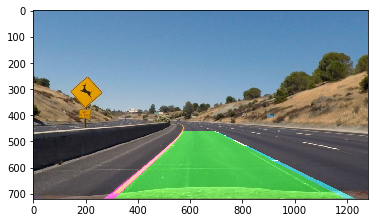

In [21]:
#19
# Draw the Detected Lane Back onto the Original Image
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    if l_fit is None or r_fit is None:
        return original_img

    new_img = np.copy(original_img)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result


exampleImg_out1 = draw_lane(exampleImg_undistorted, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)

### Draw Curvature Radius and Distance from Center Data onto the Original Image

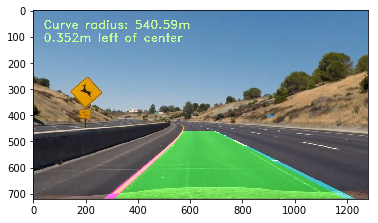

In [22]:
#20
# Draw Curvature Radius and Distance from Center Data onto the Original Image
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)

### a Line Class

In [23]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None

        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


### Define Complete Image Processing Pipeline

In [24]:
def process_image(img):
#    new_img = np.copy(img)
#    undistorted,combined,img_bin, Minv = pipeline(new_img)
    copy_img = np.copy(img)
    new_img,combined,img_bin, Minv = pipeline(copy_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
        diagnostic_output = True
    else:
        img_out = new_img
        diagnostic_output = False

    return img_out


## Pipeline (video)

#### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Please see the video file named 'project_video_output.mp4' in current folder.

### Process Project Video

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

### Process Challenge Video

In [25]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [03:50<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 30s, sys: 33.9 s, total: 3min 4s
Wall time: 3min 53s


### Process Harder Challenge Video

In [ ]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

## Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The main problem I had struggled was to identify the best/optimal color transform and gradients.
Sudden lighting change are very weak for my setting this time.

In this project, I utilzed narrowing the window for polyfitting section to avoid picking up noise pixels. But I am not satisfied with this since this approach is not globally optimal.
To make this algorithm more robust, some sort of smoothing factor should be included in the lane detection function. 